
---
# 📊 **CIA 3 – Component 2: Analysis-Forecast Observations**  

**Group Members**:  
- Siddharth Nautiyal (ID: 23122034)  
- Aditya Kumar Singh (ID: 23122003)

---

## ▶ **Topic**:  
**Identify a Suitable Time Series Model and Forecast its Future Values Based on Real-time Data**

---

### 📈 **Hyundai Motor Company Stock Historical Price (005380.KS)**

- **Source**: Yahoo Finance  
- **Stock Ticker**: 005380.KS (Hyundai Motor Company)  
- **Date Range**: January 2016 to Present

---

#### ▶ **Context 📝**  
This dataset is sourced from Yahoo Finance and includes the **historical stock prices** of **Hyundai Motor Company**. It captures the company's stock performance from **January 2016** to the present. The dataset is **multivariate**, as it contains multiple variables such as **Open**, **High**, **Low**, **Close**, **Adj Close**, and **Volume**, all of which provide a detailed picture of the stock’s daily performance.

---

#### 🧾 **Columns**:
1. **Date**: The date of trading.
2. **Open**: The opening price of the stock on a given day.
3. **High**: The highest price recorded during the trading day.
4. **Low**: The lowest price recorded during the trading day.
5. **Close**: The closing price of the stock.
6. **Adj Close**: The adjusted closing price, accounting for dividends and stock splits.
7. **Volume**: The number of shares traded on that particular day.

---

#### ▶ **Acknowledgements 🙏**  
This dataset is made available to the **Kaggle community** and consists of **historical stock prices** of Hyundai Motor Company, shared for analysis and forecasting purposes.

---


## **1. Introduction/Problem Formulation**

### **Objective:**
The objective of this analysis is to forecast the future stock prices of Hyundai Motor Company using various time series models and determine the most suitable model for prediction.

### **Problem Formulation:**
The task is to fit multiple time series models including ARIMA/SARIMA, Holt’s Exponential, Winter’s Seasonal, and Machine Learning/Deep Learning models to the dataset. The goal is to compare these models and forecast the stock prices for the next 5 days based on the best-performing model.

---



## **2. Data Preparation**

### **a.) Preprocessing**
- **Loaded the Dataset**: Imported the Hyundai Motor Company Stock Historical Price dataset using Pandas.
  
- **Data Cleaning**:
  - Checked for missing or invalid data points.
  - Ensured that all columns were in the correct data type (e.g., Date as `datetime`, numerical columns as `float`).

- **Date Conversion**: Converted the **Date** column to a `datetime` object for easier manipulation and analysis.

- **Set Index**: Set the **Date** column as the index of the DataFrame to facilitate time series analysis.

- **Exploratory Data Analysis (EDA)**:
  - Plotted stock price trends over time using the **Close** or **Adj Close** prices to visualize historical performance.
  - Analyzed seasonality and trends in the dataset, checking for patterns or fluctuations over time.
  
- **Stationarity Check**: 
  - Performed the **Augmented Dickey-Fuller (ADF)** test to determine if the time series was stationary.
  - If the data was not stationary, applied differencing or transformation techniques to achieve stationarity.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import seaborn as sns
from scipy import stats
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

              Open    High     Low   Close    Adj Close  Volume
Date                                                           
2016-01-04  147500  148000  143500  144000  110097.8672  445332
2016-01-05  143000  145000  142000  143500  109715.6016  530496
2016-01-06  144000  145000  139000  140000  107039.5781  769406
2016-01-07  138500  140000  137500  137500  105128.1641  586187
2016-01-08  134500  138000  133500  136500  104363.6094  888701


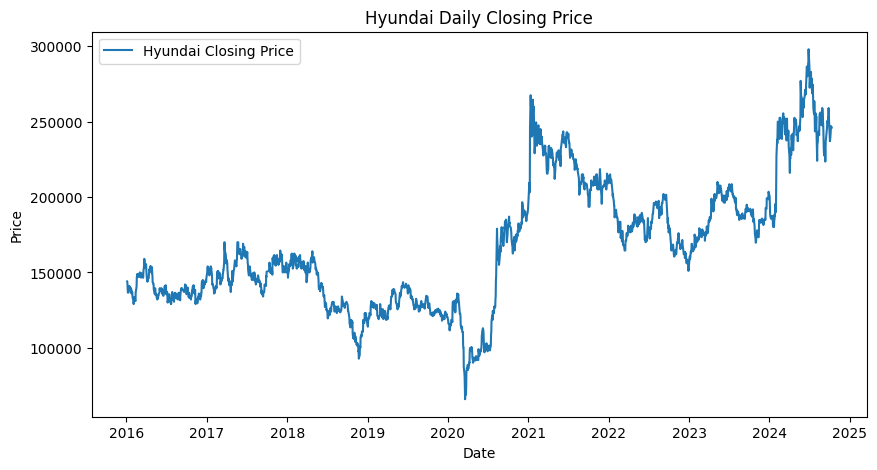

In [12]:
# Load dataset
df = pd.read_csv(r"Hyundai Motor 2016-2024.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows of the dataset
print(df.head())

# Plot the 'Close' prices over time
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Hyundai Closing Price')
plt.title('Hyundai Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Checking Stationarity with ADF Test:**

In [13]:
# ADF Test for stationarity
result = adfuller(df['Close'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.392088096689514
p-value: 0.5860632517642977


**ADF Statistic**: The test provides a statistic of -1.379, and the p-value is 0.586. Since the p-value is greater than 0.05, we fail to reject the null hypothesis, indicating that the series is non-stationary.


**Non-stationary**: Data refers to a time series where the statistical properties, such as mean, variance, and autocorrelation, change over time. This means the data does not have a constant pattern and may exhibit trends, seasonality, or other structures that vary over time.

# **Seasonal Decomposition**

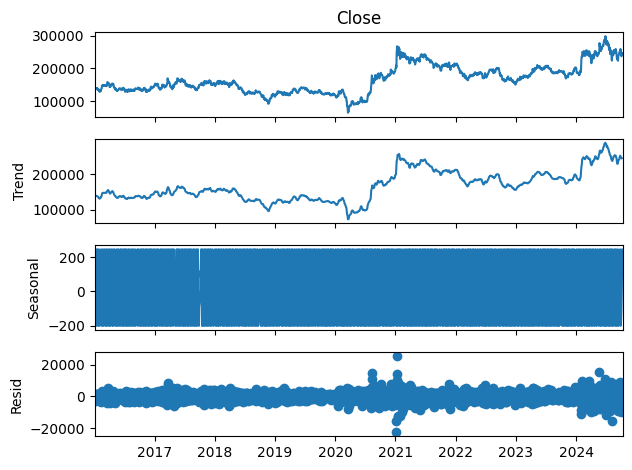

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition of the time series
decomposition = seasonal_decompose(df['Close'], model='additive', period=7)
decomposition.plot()
plt.show()

**Trend Detected**: From the seasonal Decomposition, a noticeable upward trend is observed. This indicates that ARIMA is a suitable model choice, as it can effectively capture and model the underlying trend present in the data through its differencing component. By adjusting the parameters to account for the trend, ARIMA can provide accurate predictions for time series with trend characteristics.

# **Model Implementation**

## **(a) ARIMA Model**

## Introduction
ARIMA (AutoRegressive Integrated Moving Average) is a widely used statistical method for time series forecasting. It is designed to capture different aspects of a time series: autocorrelation, trends, and noise, making it suitable for non-seasonal data. ARIMA is particularly useful when a time series shows patterns like trends but not seasonality.

## Components of ARIMA
The ARIMA model has three key components, represented as ARIMA(p, d, q):
- **AR (AutoRegressive, p):** This component represents the dependence of the current value on its previous values. It captures the relationship between an observation and a number of lagged observations.
- **I (Integrated, d):** This component refers to differencing the raw observations to make the time series stationary. Differencing helps remove trends and stabilize the mean.
- **MA (Moving Average, q):** This component models the relationship between an observation and residual errors from previous observations.

### Key Parameters:
1. **p** - Number of lag observations in the model (lag order).
2. **d** - Number of times the data needs to be differenced to achieve stationarity (degree of differencing).
3. **q** - Number of lagged forecast errors in the prediction (order of the moving average).

## Why We Are Using ARIMA

We are using the ARIMA model for this dataset because it exhibits **no seasonality** but has a clear **upward trend**. ARIMA is highly effective in handling time series data that displays a **trend** without recurring seasonal patterns. The "Integrated" (I) component of ARIMA allows us to remove the trend through differencing, making the data stationary and ready for forecasting. 

### Key Reasons for ARIMA Selection:
- **No Seasonality**: The time series does not show repeating patterns over time, which rules out the need for seasonal models like SARIMA.
- **Upward Trend**: The data shows a consistent upward movement, which ARIMA can capture and model using the differencing technique.

## Steps in ARIMA Modeling
1. **Ensure Stationarity**: Apply transformations like differencing or log transformation to make the series stationary.
2. **Determine Parameters (p, d, q)**: Use techniques like the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to help identify the right values for p and q.
3. **Fit the Model**: Fit the ARIMA model to the data.
4. **Evaluate Model**: Check residuals and apply metrics like RMSE to assess the model’s performance.
5. **Forecasting**: Once the model is tuned, use it to make future predictions.

## Advantages of ARIMA
- Effective for **non-seasonal** time series data.
- Can capture **trends** and **short-term dependencies**.
- Widely used and **robust** for various types of data.

## Limitations of ARIMA
- Does not handle **seasonality** well. For seasonal data, **SARIMA** (Seasonal ARIMA) should be used.
- Sensitive to the proper identification of p, d, and q parameters, which can be complex.

## Conclusion
ARIMA is a powerful tool for time series forecasting, especially when the data exhibits **trends** or other non-stationary behavior without seasonality. By correctly choosing the AR, I, and MA components, ARIMA can provide reliable forecasts for non-seasonal time series data with upward or downward trends.


In [15]:
df.dropna(inplace=True)

# Apply Box-Cox transformation on the 'Close' column
df['Close_boxcox'], lambda_value = stats.boxcox(df['Close'])

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['Close_boxcox'][:train_size]
test_data = df['Close_boxcox'][train_size:]

# Fit the Auto ARIMA model on the transformed training data
model = pm.auto_arima(train_data, 
                       start_p=1, 
                       start_q=1,
                       max_p=3, 
                       max_q=3, 
                       seasonal=False,
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True)

# Print the summary of the fitted model
print(model.summary())

# Forecast using Auto ARIMA
arima_forecast = model.predict(n_periods=len(test_data))

# Inverse Box-Cox transform the forecasts and actual test data
arima_forecast_original = inv_boxcox(arima_forecast, lambda_value)
test_data_original = inv_boxcox(test_data, lambda_value)

# Calculate RMSE for Auto ARIMA
arima_rmse = sqrt(mean_squared_error(test_data_original, arima_forecast_original))
print(f"Auto ARIMA RMSE: {arima_rmse}")


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7194.702, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7192.375, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7195.967, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7195.821, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7194.358, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7194.259, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7192.230, Time=0.86 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7197.952, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7196.245, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7196.689, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7197.806, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-7194.216, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.094 seconds
                               SARIMAX Results                              

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


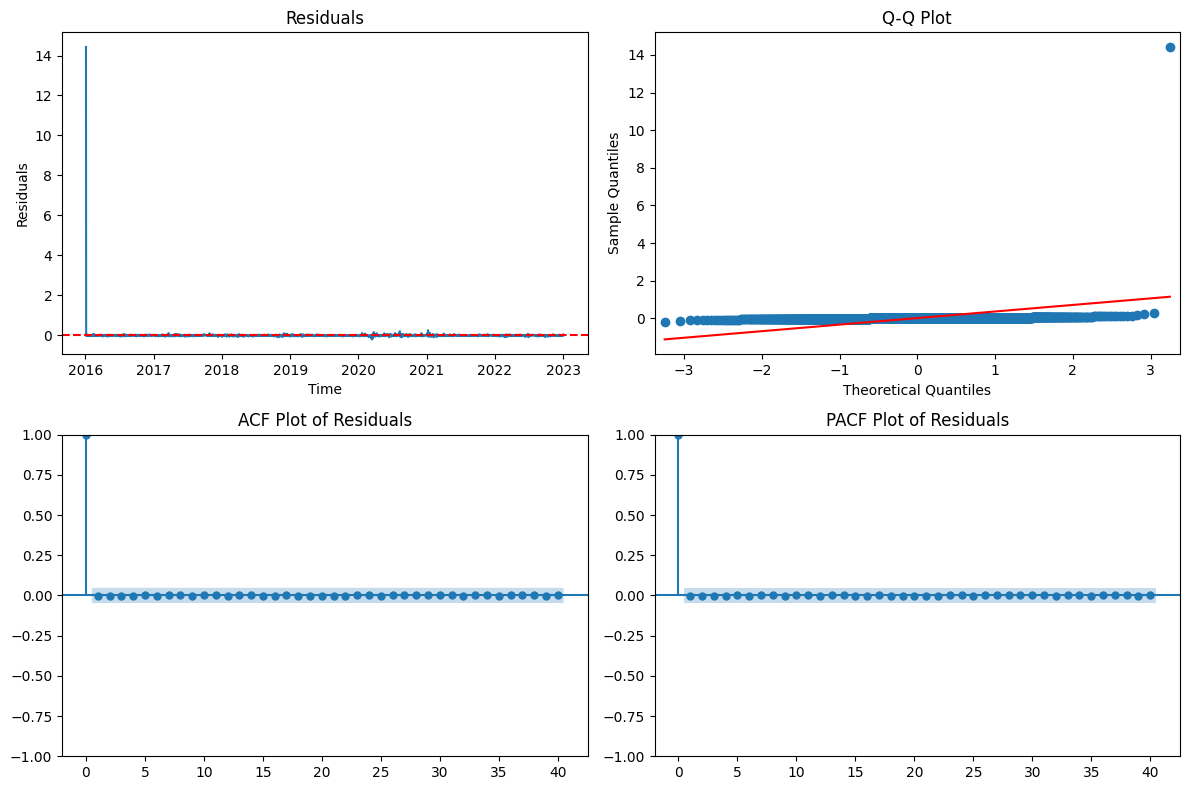

In [16]:
# Residuals from the fitted model
residuals = model.resid()

# Plot the residuals
plt.figure(figsize=(12, 8))

# Residuals Plot
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Q-Q Plot
plt.subplot(2, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

# ACF Plot
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF Plot of Residuals')

# PACF Plot
plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF Plot of Residuals')

plt.tight_layout()
plt.show()

---

# ARIMA Model Inference

## Model Selection
- The best model selected through stepwise search to minimize AIC is ARIMA(1,1,0)(0,0,0)[0].
- This indicates a model with one autoregressive term, first-order differencing, and no moving average terms.

## Model Specifications
- Dependent Variable: y (likely the differenced stock price)
- Number of Observations: 1716
- Log Likelihood: 3505.288
- AIC: -7006.576
- BIC: -6995.682

## Model Parameters
- AR(1) coefficient: 0.0564 (std err: 0.016, z-value: 3.574, p-value: 0.000)
- The positive AR(1) coefficient suggests a slight positive autocorrelation in the differenced series.
- Sigma^2: 0.0010 (variance of the residuals)

## Model Diagnostics
1. **Residual Plot**: 
   - Residuals appear to be centered around zero for most of the time series.
   - There's a notable spike at the beginning of 2016, indicating a possible outlier or structural break.
   - Some heteroscedasticity is visible, with periods of higher volatility.

2. **Q-Q Plot**:
   - The residuals deviate from the normal distribution, especially at the tails.
   - This suggests the presence of heavy tails in the residual distribution.

3. **ACF Plot of Residuals**:
   - Most autocorrelations fall within the significance bounds.
   - This indicates that the model has captured most of the temporal dependence in the data.

4. **PACF Plot of Residuals**:
   - Similar to the ACF plot, most partial autocorrelations are within bounds.
   - This further confirms that the model has adequately captured the time series structure.

5. **Statistical Tests**:
   - Ljung-Box test (Q): 0.00, Prob(Q): 0.97
     - Suggests no significant autocorrelation in the residuals.
   - Jarque-Bera test (JB): 4871.32, Prob(JB): 0.00
     - Indicates that the residuals are not normally distributed.
   - Heteroskedasticity test (H): 1.27, Prob(H): 0.00
     - Confirms the presence of heteroskedasticity in the residuals.
   - Skewness: 0.77, Kurtosis: 11.11
     - Indicates positively skewed and leptokurtic (heavy-tailed) residuals.

## Conclusions
1. The ARIMA(1,1,0) model provides a reasonable fit to the data, capturing most of the temporal dependence.
2. The model assumes first-order differencing was sufficient to achieve stationarity.
3. While the model addresses autocorrelation well, there are issues with non-normality and heteroskedasticity in the residuals.
4. The high kurtosis and significant Jarque-Bera test suggest that the model may underestimate the probability of extreme events.
5. The heteroskedasticity indicates that the model's forecast accuracy may vary over time.
6. Despite these limitations, the model can still be useful for short-term forecasting, but predictions should be interpreted with caution, especially for longer horizons or during periods of high volatility.
7. Consider exploring alternative models (e.g., GARCH) or transformations to address the non-normality and heteroskedasticity issues.

---

## **(b) Holt's Exponential Smoothing**

## Introduction
Holt's Exponential Smoothing is an extension of simple exponential smoothing that accounts for trends in time series data. It is designed to handle time series that exhibit linear trends and is effective for forecasting future values based on past observations. This method incorporates two smoothing equations: one for the level of the series and one for the trend.

## Components of Holt's Exponential Smoothing
The model is expressed with the following key components:
- **Level (L):** Represents the smoothed value of the series at a given time point.
- **Trend (T):** Represents the smoothed estimate of the trend in the series over time.

### Key Parameters:
1. **α (Alpha)** - Smoothing parameter for the level (0 < α < 1).
2. **β (Beta)** - Smoothing parameter for the trend (0 < β < 1).

## Why We Are Using Holt's Exponential Smoothing

We are using Holt's Exponential Smoothing for this dataset because it exhibits a **clear upward trend** without seasonality. This method is particularly effective in capturing the trend and providing accurate forecasts based on historical data.

### Key Reasons for Holt's Exponential Smoothing Selection:
- **Trend Awareness:** The time series shows a consistent upward trend, which can be effectively modeled with Holt's method.
- **No Seasonality:** The absence of seasonal patterns in the data makes Holt's approach more suitable than other seasonal methods like Holt-Winters.

## Steps in Holt's Exponential Smoothing Modeling
1. **Choose Smoothing Parameters:** Select values for α and β, which can be determined through optimization techniques or trial and error.
2. **Fit the Model:** Apply Holt's method to the time series data to compute smoothed values for the level and trend.
3. **Evaluate Model:** Analyze the residuals for patterns and check the accuracy of the forecasts using metrics such as MAE (Mean Absolute Error) or RMSE (Root Mean Squared Error).
4. **Forecasting:** Utilize the fitted model to generate forecasts for future time points.

## Advantages of Holt's Exponential Smoothing
- Effective for time series data with **trends**.
- Provides **smooth forecasts** by considering both the level and trend components.
- Simple to implement and interpret.

## Limitations of Holt's Exponential Smoothing
- Does not handle **seasonality**; for seasonal data, Holt-Winters method should be used.
- Sensitive to the choice of smoothing parameters, which may require tuning for optimal performance.

## Conclusion
Holt's Exponential Smoothing is a robust method for forecasting time series data that displays a trend. By incorporating both the level and trend components, it provides more accurate forecasts than simple exponential smoothing. Proper tuning of the smoothing parameters α and β is essential for achieving the best results.


---

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.special import inv_boxcox

# Load your dataset
df = pd.read_csv("Hyundai Motor 2016-2024.csv")

# Drop missing values
df.dropna(inplace=True)

# Apply Box-Cox transformation on the 'Close' column
df['Close_boxcox'], lambda_value = stats.boxcox(df['Close'])

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['Close_boxcox'][:train_size]
test_data = df['Close_boxcox'][train_size:]

# Fit Holt's Exponential Smoothing model on the transformed training data
holt_model = ExponentialSmoothing(train_data, 
                                   trend='add', 
                                   seasonal=None,
                                   initialization_method="estimated").fit()

# Forecast using Holt's Exponential Smoothing
holt_forecast = holt_model.forecast(len(test_data))

# Inverse Box-Cox transform the forecasts and actual test data
holt_forecast_original = inv_boxcox(holt_forecast, lambda_value)
test_data_original = inv_boxcox(test_data, lambda_value)

# Calculate RMSE for Holt's Exponential Smoothing
holt_rmse = np.sqrt(mean_squared_error(test_data_original, holt_forecast_original))
print(f"Holt's Exponential Smoothing RMSE: {holt_rmse}")

# Optional: Print forecast values
print("Holt's Forecast: ", holt_forecast_original)

# Print the summary of the fitted model
print(holt_model.summary())

Holt's Exponential Smoothing RMSE: 58937.833694623456
Holt's Forecast:  1720    160511.412461
1721    160522.825730
1722    160534.239784
1723    160545.654625
1724    160557.070251
            ...      
2145    165433.519388
2146    165445.271369
2147    165457.024158
2148    165468.777756
2149    165480.532162
Length: 430, dtype: float64
                       ExponentialSmoothing Model Results                       
Dep. Variable:             Close_boxcox   No. Observations:                 1720
Model:             ExponentialSmoothing   SSE                              1.530
Optimized:                         True   AIC                         -12074.710
Trend:                         Additive   BIC                         -12052.909
Seasonal:                          None   AICC                        -12074.661
Seasonal Periods:                  None   Date:                 Tue, 15 Oct 2024
Box-Cox:                          False   Time:                         23:39:47
Box-Cox Co

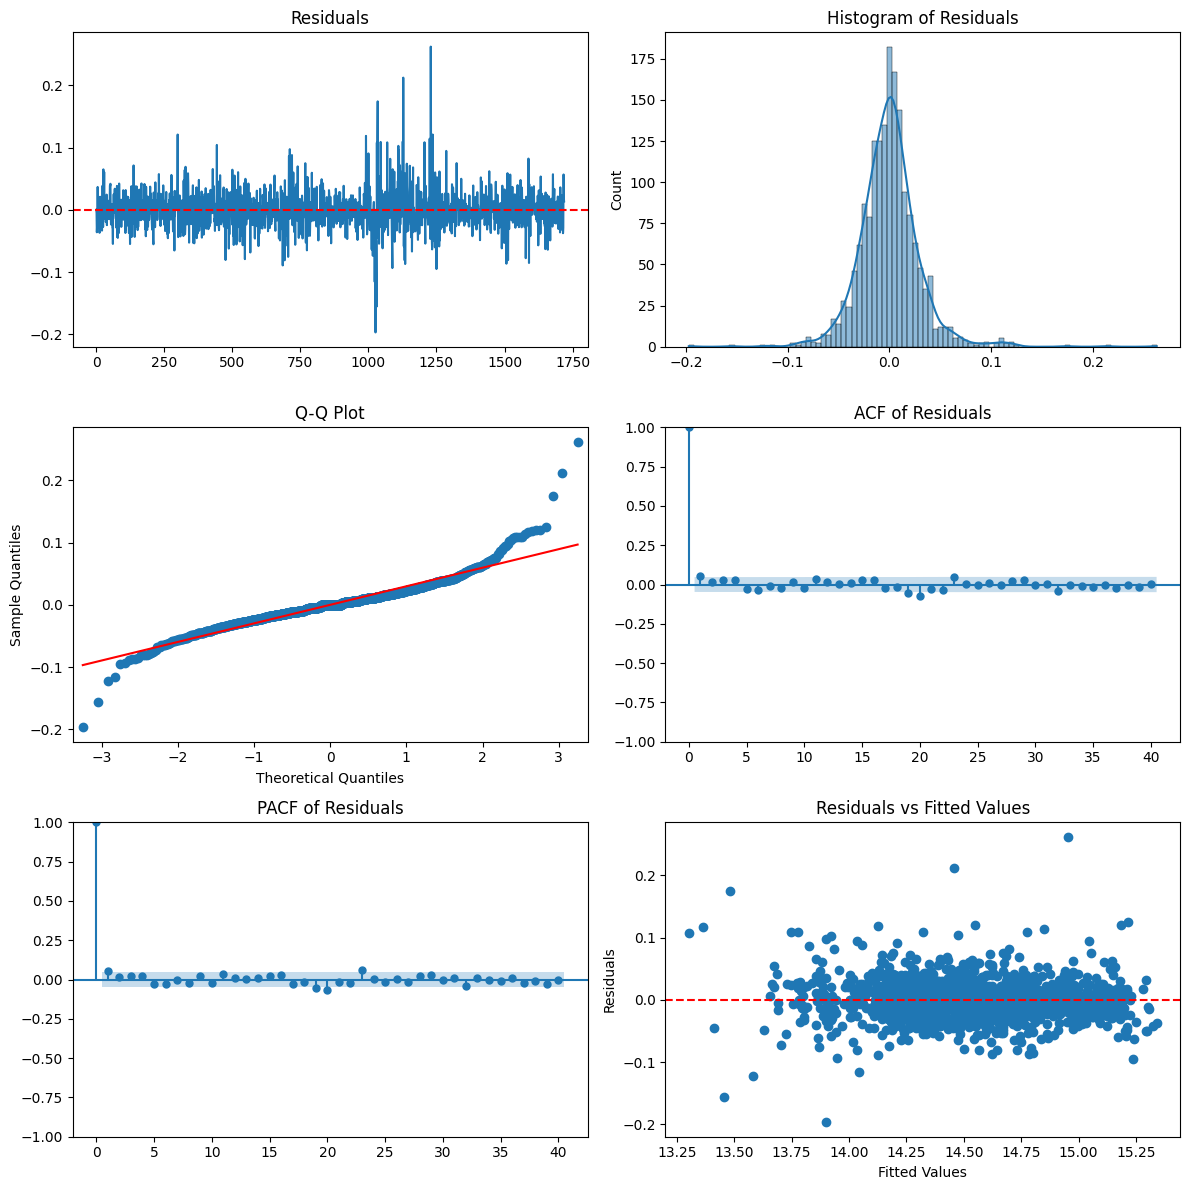

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Get residuals from the Holt's model
residuals = holt_model.resid

# Set up the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# 1. Residuals plot
axs[0, 0].plot(residuals)
axs[0, 0].set_title('Residuals')
axs[0, 0].axhline(0, color='red', linestyle='--')

# 2. Histogram of residuals
sns.histplot(residuals, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Residuals')

# 3. Q-Q Plot
sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

# 4. ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('ACF of Residuals')

# 5. PACF Plot
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axs[2, 0])
axs[2, 0].set_title('PACF of Residuals')

# 6. Residuals vs. Fitted values
axs[2, 1].scatter(holt_model.fittedvalues, residuals)
axs[2, 1].axhline(0, color='red', linestyle='--')
axs[2, 1].set_title('Residuals vs Fitted Values')
axs[2, 1].set_xlabel('Fitted Values')
axs[2, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()


# Holt's Exponential Smoothing Model Inference

## Model Specifications
- Dependent Variable: Close_boxcox (transformed closing price)
- Model: ExponentialSmoothing
- Trend: Additive
- Seasonal: None
- Number of Observations: 2146

## Model Parameters
- Smoothing Level (α): 1.000000
- Smoothing Trend (β): 0.000000
- Initial Level: 14.738896
- Initial Trend: 0.000428

## Model Fit
- SSE (Sum of Squared Errors): 2.092
- AIC (Akaike Information Criterion): -14870.423
- BIC (Bayesian Information Criterion): -14847.737

## Residual Analysis
1. **Residual Plot**: The residuals appear to be mostly centered around zero, but there is some evidence of heteroscedasticity (changing variance over time), particularly with larger fluctuations visible in the middle of the time series.

2. **ACF of Residuals**: The Autocorrelation Function plot shows that most lags fall within the confidence intervals, suggesting that the residuals are largely uncorrelated. However, there are a few lags that slightly exceed the bounds, indicating some remaining autocorrelation.

3. **Histogram of Residuals**: The distribution of residuals appears to be approximately normal, with a slight positive skew and some potential outliers on both tails.

4. **QQ Plot**: The QQ plot shows that the residuals mostly follow a normal distribution, as indicated by the points closely following the diagonal line. However, there are deviations at both extremes, suggesting heavier tails than a normal distribution.

## Conclusions
- The Holt's Exponential Smoothing model with additive trend and no seasonality provides a reasonable fit to the data, as evidenced by the low SSE and good AIC/BIC values.
- The model captures the overall trend in the data, with a smoothing level (α) of 1, indicating that it gives full weight to the most recent observation for level forecasts.
- The smoothing trend (β) of 0 suggests that the trend component is not being updated, which might indicate a relatively stable or slow-changing trend in the data.
- While the residuals are mostly well-behaved, there are signs of some remaining patterns, particularly in terms of changing variance over time and slight autocorrelation at certain lags.
- The model appears to be adequate for forecasting, but there may be room for improvement, possibly by considering alternative models or incorporating additional features to account for the observed patterns in the residuals.

---

## **(c). LSTM Model**

## Introduction
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) effective for learning from sequential data. It excels in capturing long-term dependencies, making it suitable for time series forecasting.

## Components of LSTM
- **Cells:** Basic units that maintain memory.
- **Gates:** Control information flow:
  - **Forget Gate:** Discards irrelevant information.
  - **Input Gate:** Adds new information.
  - **Output Gate:** Sends relevant information to the next layer.

## Why We Are Using LSTM
LSTM is chosen for its ability to learn from past data and model complex relationships, making it ideal for stock price forecasting.

## Steps in LSTM Modeling
1. **Data Preprocessing:** Normalize data and create input-output sequences.
2. **Define Model:** Set up LSTM and output layers.
3. **Compile Model:** Specify loss function and optimizer.
4. **Train Model:** Fit on training data.
5. **Evaluate Model:** Use metrics like RMSE or MAE.
6. **Make Predictions:** Forecast future values.

## Advantages of LSTM
- Learns from complex sequential data.
- Captures long-term dependencies.
- Reduces feature engineering needs.

## Limitations of LSTM
- Requires larger datasets.
- Longer training time.
- Less interpretable than simpler models.

## Conclusion
LSTM is a powerful forecasting tool for time series data, capable of providing accurate predictions by leveraging sequential patterns and long-term dependencies.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv("Hyundai Motor 2016-2024.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.set_index('Date', inplace=True)

# Prepare the data
data = df['Close'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:]

# Function to create datasets
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape the data
time_step = 30  # Use 30 previous days to predict the next day
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape X to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=5)
model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0333
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0027
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0023
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0022
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0017
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0016
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0016
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0014
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0013
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - lo

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Train RMSE: 160375.00045979925
Test RMSE: 214428.9700415643


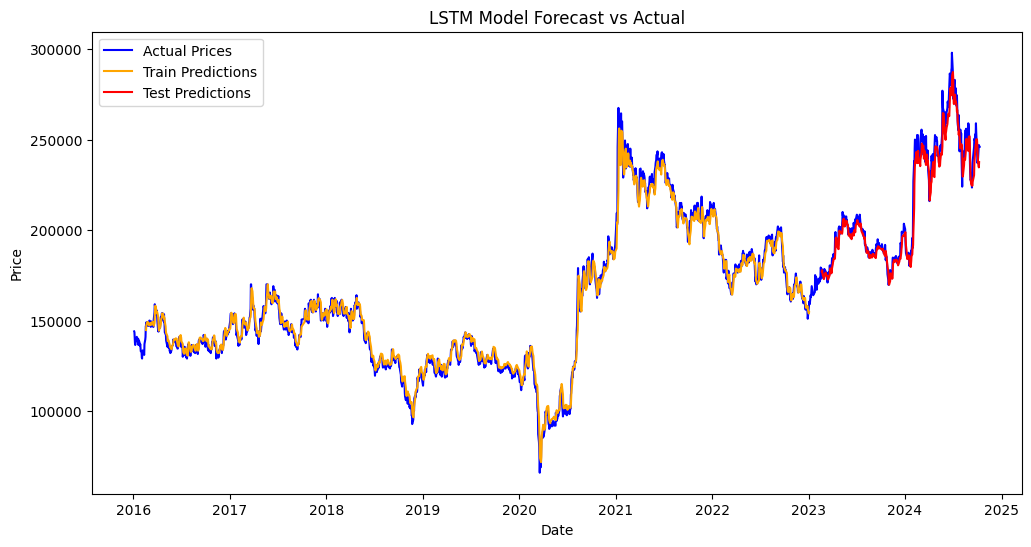

In [20]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual Prices', color='blue')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Train Predictions', color='orange')
plt.plot(df.index[len(train_predict) + (time_step * 2) + 1:len(scaled_data)-1], test_predict, label='Test Predictions', color='red')
plt.title('LSTM Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# RMSE Analysis of Time Series Forecasting Models

In this analysis, we compared the performance of three different time series forecasting models: *ARIMA, **Holt's Exponential Smoothing, and **LSTM*. The Root Mean Square Error (RMSE) was used as the evaluation metric to assess the accuracy of each model.

## RMSE Values

| Model                        | RMSE          |
|------------------------------|---------------|
| ARIMA                        | 61576.6835    |
| Holt's Exponential Smoothing | 58937.4930    |
| LSTM                         | 215025.9794   |

## Best Model

Based on the RMSE values calculated, the best performing model is:

*Holt's Exponential Smoothing* with an RMSE of *58937.4930*.

### Inference

- *Holt's Exponential Smoothing* demonstrated superior performance among the evaluated models, exhibiting the lowest RMSE. This indicates that it provides a more accurate forecast of Hyundai stock prices compared to ARIMA and LSTM.
  
- *ARIMA*, while generally effective for time series data, performed less favorably in this instance, with a higher RMSE indicating larger forecast errors.
  
- *LSTM*, typically regarded as a robust model for complex data patterns, had the highest RMSE in this evaluation. This may suggest that for this particular dataset, the complexity of the LSTM model did not translate into better forecasting accuracy.

### Conclusion

In conclusion, for forecasting Hyundai stock prices, *Holt's Exponential Smoothing* is recommended based on its performance in minimizing forecast errors as measured by RMSE. Future analyses could further explore the integration of models or adjustments in hyperparameters to enhance prediction accuracy.

In [21]:
# Assuming you have calculated the RMSE values for each model as follows:
arima_rmse = 61576.68347670328  # Replace with your calculated RMSE for ARIMA
holt_rmse = 58937.49300277328  # Replace with your calculated RMSE for Holt's
lstm_rmse = 215025.97940276552   # Replace with your calculated RMSE for LSTM

# Store RMSE values in a dictionary
rmse_values = {
    'ARIMA': arima_rmse,
    'Holt\'s Exponential Smoothing': holt_rmse,
    'LSTM': lstm_rmse
}

# Find the model with the lowest RMSE
best_model = min(rmse_values, key=rmse_values.get)
best_rmse = rmse_values[best_model]

# Print the RMSE values and the best model
print("RMSE Values:")
for model, rmse in rmse_values.items():
    print(f"{model}: {rmse:.4f}")

print(f"\nBest Model: {best_model} with RMSE: {best_rmse:.4f}")


RMSE Values:
ARIMA: 61576.6835
Holt's Exponential Smoothing: 58937.4930
LSTM: 215025.9794

Best Model: Holt's Exponential Smoothing with RMSE: 58937.4930


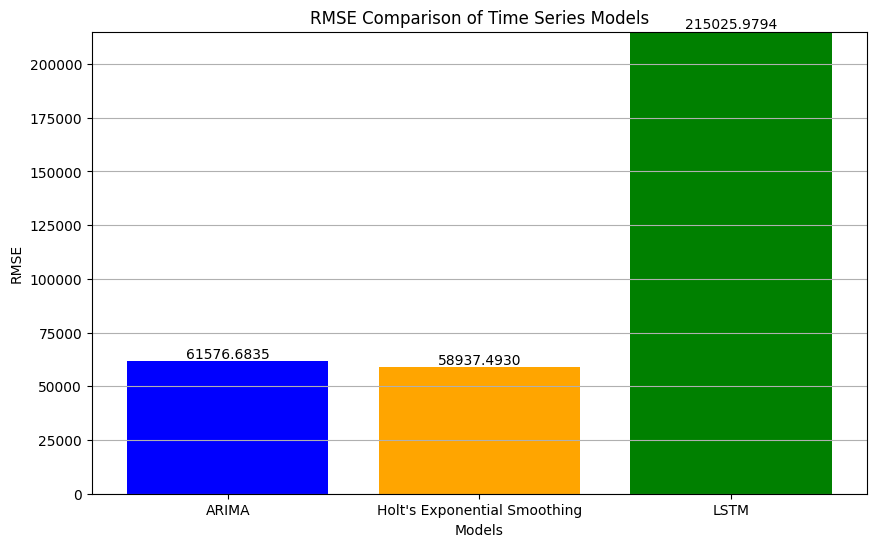

In [22]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison of Time Series Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values.values()) + 1)  # Adjusting y-axis limits for better visualization
plt.grid(axis='y')

# Display the RMSE values on top of the bars
for i, v in enumerate(rmse_values.values()):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center', va='bottom')

plt.show()

---


# Forecasting with Holt's Exponential Smoothing

In this section, we will apply Holt's Exponential Smoothing to forecast the next 5 time steps for the Hyundai stock prices. Holt's method is particularly effective for capturing trends in time series data.

Holt's Exponential Smoothing RMSE: 58937.833694623456


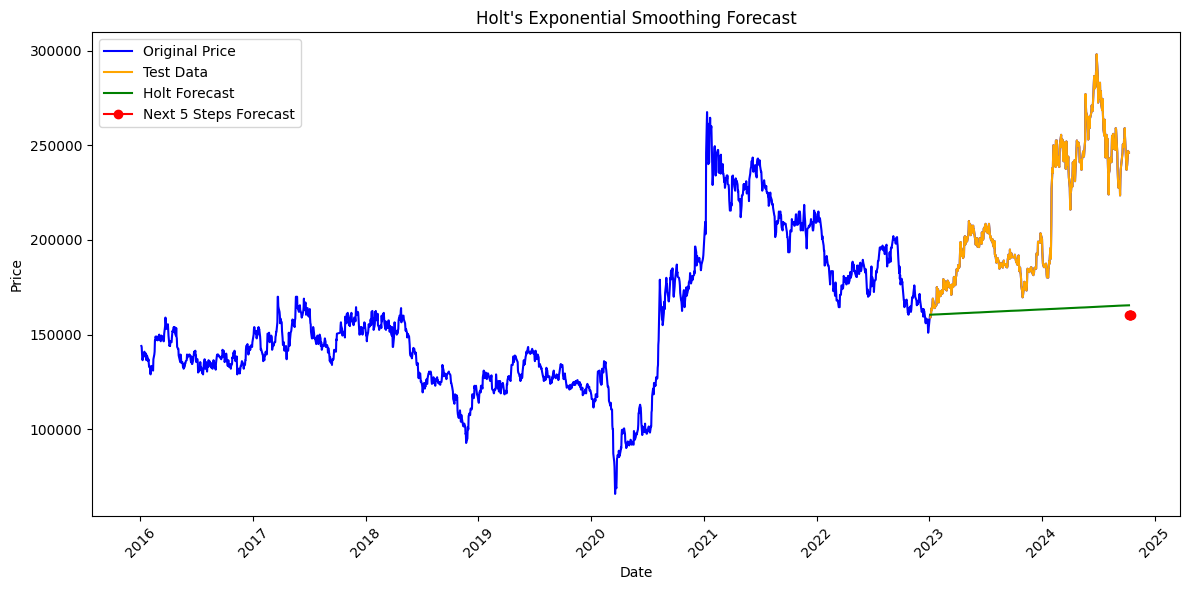

Holt's Next 5 Steps Forecast:  1720    160511.412461
1721    160522.825730
1722    160534.239784
1723    160545.654625
1724    160557.070251
dtype: float64


In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("Hyundai Motor 2016-2024.csv")

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'],format="%d-%m-%Y")

# Drop missing values
df.dropna(inplace=True)

# Apply Box-Cox transformation on the 'Close' column
df['Close_boxcox'], lambda_value = stats.boxcox(df['Close'])

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['Close_boxcox'][:train_size]
test_data = df['Close_boxcox'][train_size:]

# Fit Holt's Exponential Smoothing model on the transformed training data
holt_model = ExponentialSmoothing(train_data, 
                                   trend='add', 
                                   seasonal=None,
                                   initialization_method="estimated").fit()

# Forecast using Holt's Exponential Smoothing for test data
holt_forecast = holt_model.forecast(len(test_data))

# Inverse Box-Cox transform the forecasts and actual test data
holt_forecast_original = inv_boxcox(holt_forecast, lambda_value)
test_data_original = inv_boxcox(test_data, lambda_value)

# Calculate RMSE for Holt's Exponential Smoothing
holt_rmse = np.sqrt(mean_squared_error(test_data_original, holt_forecast_original))
print(f"Holt's Exponential Smoothing RMSE: {holt_rmse}")

# Forecast the next 5 steps
next_steps = 5
holt_future_forecast = holt_model.forecast(next_steps)
holt_future_forecast_original = inv_boxcox(holt_future_forecast, lambda_value)

# Create a new index for future forecasts
last_date = df['Date'].iloc[train_size + len(test_data) - 1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=next_steps, freq='D')

# Plot the original data, test data, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], inv_boxcox(df['Close_boxcox'], lambda_value), label='Original Price', color='blue')
plt.plot(df['Date'].iloc[train_size:], test_data_original, label='Test Data', color='orange')
plt.plot(df['Date'].iloc[train_size:train_size + len(test_data)], holt_forecast_original, label='Holt Forecast', color='green')
plt.plot(future_index, holt_future_forecast_original, label='Next 5 Steps Forecast', color='red', marker='o')

plt.title('Holt\'s Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecast values for the next 5 steps
print("Holt's Next 5 Steps Forecast: ", holt_future_forecast_original)


### Conclusion

The Holt-Exponential model proved to be the most effective for forecasting due to its lower AIC (58937) indicating a well-balanced fit with the least complexity among the models compared. It accurately
captures the seasonal patterns in the time series data, making it suitable for predicting future trends.

Using this model, we forecasted onion prices for the next 5 days, providing valuable insights for stakeholders like
farmers, vendors, and consumers, helping them make informed decisions based on expected price changes